In [ ]:
import cv2
import numpy as np
from PIL import Image
import dlib
import os
from tensorflow.keras import datasets, layers, models
from keras.callbacks import ModelCheckpoint

IMG_SIZE=227

def distance(a, b):
	return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def shape_to_normal(shape):
	shape_normal = []
	for i in range(0, 5):
		shape_normal.append((shape.part(i).x, shape.part(i).y))
	return shape_normal

def angle_opposite_to_line3(length_line1, length_line2, length_line3):
	cos_value = (length_line1**2 + length_line2**2 - length_line3**2) / (2*length_line2*length_line1)
	return np.arccos(cos_value)

def align_and_resize_image(img):
	##### align image ############################
	predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	x = 0
	y = 0
	w = gray.shape[0]
	h = gray.shape[1]
	rect=dlib.rectangle(x,y,w,h)
	shape = predictor(gray, rect)

	shape = shape_to_normal(shape)
	# shape has 5 point 4 nose 2 3 left eye 0 1 right eye
	# https://www.pyimagesearch.com/2018/04/02/faster-facial-landmark-detector-with-dlib/
	nose = shape[4]
	left_eye = [int(shape[2][0]+shape[3][0])/2,int(shape[2][1]+shape[3][1])/2]
	right_eye = [int(shape[0][0]+shape[1][0])/2,int(shape[0][1]+shape[1][1])/2]

	center_of_forehead = ((left_eye[0] + right_eye[0])/2, (left_eye[1] + right_eye[1])/2)

	center_image_top = [nose[0],0]
	length_line1 = distance(center_of_forehead, nose)
	length_line2 = distance(center_image_top, nose)
	length_line3 = distance(center_image_top, center_of_forehead)

	angle = abs(angle_opposite_to_line3(length_line1, length_line2, length_line3))
	if center_of_forehead[0]<=nose[0]:
		angle = -1*(np.degrees(angle))
	else:
		angle = np.degrees(angle)

	# print("angle is ",angle)
	img = Image.fromarray(img)
	img = np.array(img.rotate(angle))
	# ########################### Cropping of aligned image ###################################
	img=cv2.resize(img, (IMG_SIZE, IMG_SIZE))
	# print("===crpoing=",img.shape)
	return img


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive/My\ Drive/{location you want to move}

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/My\ Drive/Colab Notebooks/age gender classification
%ls

/gdrive/My Drive/Colab Notebooks/age gender classification
 Chained_Age_Group_Prediction_OVER_Gender_Prediction.ipynb
 Gender_and_Age_Group_Prediction.ipynb
 photo/
 play.ipynb
 project1.ipynb
'saved models'/
 shape_predictor_5_face_landmarks.dat


In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
model_gender = models.Sequential()
#CONV1
model_gender.add(layers.Conv2D(96, (7, 7),strides=(4,4), input_shape=(227, 227, 3)))
model_gender.add(layers.Activation('relu'))
model_gender.add(layers.BatchNormalization())
model_gender.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_gender.add(layers.Dropout(0.7))
#CONV2
model_gender.add(layers.Conv2D(256, (5, 5)))
model_gender.add(layers.Activation('relu'))
model_gender.add(layers.BatchNormalization())
model_gender.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_gender.add(layers.Dropout(0.7))
#CONV3
model_gender.add(layers.Conv2D(384, (3, 3)))
model_gender.add(layers.Activation('relu'))
model_gender.add(layers.BatchNormalization())
model_gender.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_gender.add(layers.Dropout(0.7))
#CONV4
model_gender.add(layers.Conv2D(256, (3, 3)))
model_gender.add(layers.Activation('relu'))
model_gender.add(layers.BatchNormalization())
model_gender.add(layers.MaxPooling2D(pool_size=(3, 3)))
model_gender.add(layers.Dropout(0.7))
#flat
model_gender.add(layers.Flatten())
# FC1
model_gender.add(layers.Dense(512))
model_gender.add(layers.Activation('relu'))
model_gender.add(layers.BatchNormalization())
model_gender.add(layers.Dropout(0.7))
#FC2
model_gender.add(layers.Dense(3))
model_gender.add(layers.Activation('softmax'))

# model_gender.summary()

In [ ]:
model_age = models.Sequential()
#CONV1
model_age.add(layers.Conv2D(96, (7, 7),strides=(4,4), input_shape=(227, 227, 3)))
model_age.add(layers.Activation('relu'))
model_age.add(layers.BatchNormalization())
model_age.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_age.add(layers.Dropout(0.6))
#CONV2
model_age.add(layers.Conv2D(256, (5, 5)))
model_age.add(layers.Activation('relu'))
model_age.add(layers.BatchNormalization())
model_age.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_age.add(layers.Dropout(0.6))
#CONV3
model_age.add(layers.Conv2D(384, (3, 3)))
model_age.add(layers.Activation('relu'))
model_age.add(layers.BatchNormalization())
model_age.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_age.add(layers.Dropout(0.6))
#CONV4
model_age.add(layers.Conv2D(256, (3, 3)))
model_age.add(layers.Activation('relu'))
model_age.add(layers.BatchNormalization())
model_age.add(layers.MaxPooling2D(pool_size=(3, 3)))
model_age.add(layers.Dropout(0.6))
#flat
model_age.add(layers.Flatten())
# FC1
model_age.add(layers.Dense(512))
model_age.add(layers.Activation('relu'))
model_age.add(layers.BatchNormalization())
model_age.add(layers.Dropout(0.6))
#FC2
model_age.add(layers.Dense(8))
model_age.add(layers.Activation('softmax'))

# model_age.summary()

In [ ]:
model_gender.load_weights('saved models/Gender_Prediction_weights.best.h5')
model_age.load_weights('saved models/Age_Prediction_weights.best.h5')

In [ ]:
import math
gender=["Male","Female","Child"]
age_group=["0-2 Y","4-6 Y","8-13 Y","15-20 Y","25-32 Y","38-43 Y","48-53 Y","60+ Y"]
age_group_mean=[1,5,10.5,17.5,28.5,40.5,50.5,75]
def predict_gender(img):
  img = np.expand_dims(img, axis=0)
  result = model_gender.predict_classes(img)
  return (gender[result[0]])

def predict_age_group(img):
  img = np.expand_dims(img, axis=0)
  result = model_age.predict_classes(img)
  return (age_group[result[0]])

def predict_age_value(img):
  img = np.expand_dims(img, axis=0)
  results = model_age.predict_proba(img)
  # print(results)
  age=0
  for i in range(8):
    age+=(age_group_mean[i]*results[0][i])
  return str(str(math.ceil(age))+"Y")

In [ ]:
from google.colab.patches import cv2_imshow
import os
# import imutils
def play(ImagePath):
  img = cv2.imread(ImagePath)
  # print(img.shape)#first one is height second one is width
  # img = imutils.resize(img, width=512)
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
  image_copy = np.copy(img)
  detector = dlib.get_frontal_face_detector()
  faces = detector(gray, 1)#1 corresponds to number of time upsmaple the image
  print("Number of faces ===>",len(faces))

  for f in faces:
    x1=f.left()
    y1=f.top()-5
    x2=f.right()
    y2=f.bottom()
    cv2.rectangle(image_copy, (x1,y1), (x2, y2), (82,247,115), 2)
    mod_img=align_and_resize_image(img[y1:y2, x1:x2])
    # cv2_imshow(mod_img)
    # print(predict_age_value(mod_img))
    # print(predict_gender(mod_img))
    # cv2_imshow(mod_img)
    cv2.putText(image_copy, predict_age_group(mod_img), (x1, y1-20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)
    cv2.putText(image_copy, predict_gender(mod_img), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)

  cv2_imshow(image_copy)
  if(not os.path.isdir('results')):
    os.mkdir('results')
  image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
  enc = tf.image.encode_jpeg(image_copy)
  fname = tf.constant(ImagePath.replace("photos","results"))
  fwrite = tf.io.write_file(fname, enc)

Number of faces ===> 6


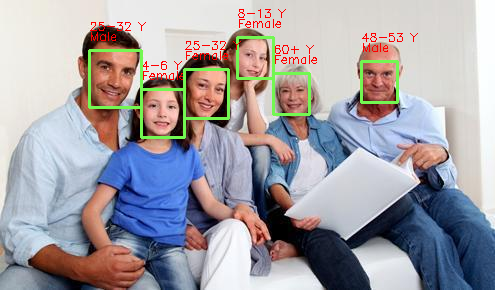

Number of faces ===> 7


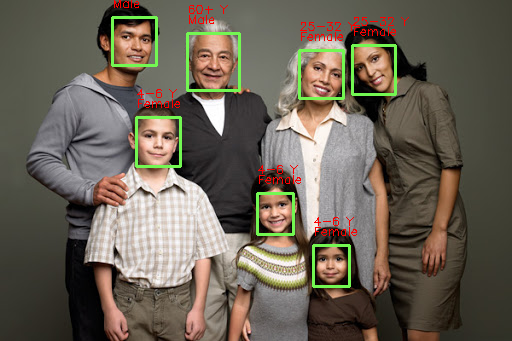

Number of faces ===> 5


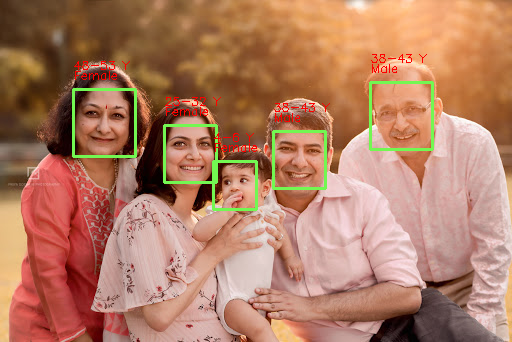

Number of faces ===> 5


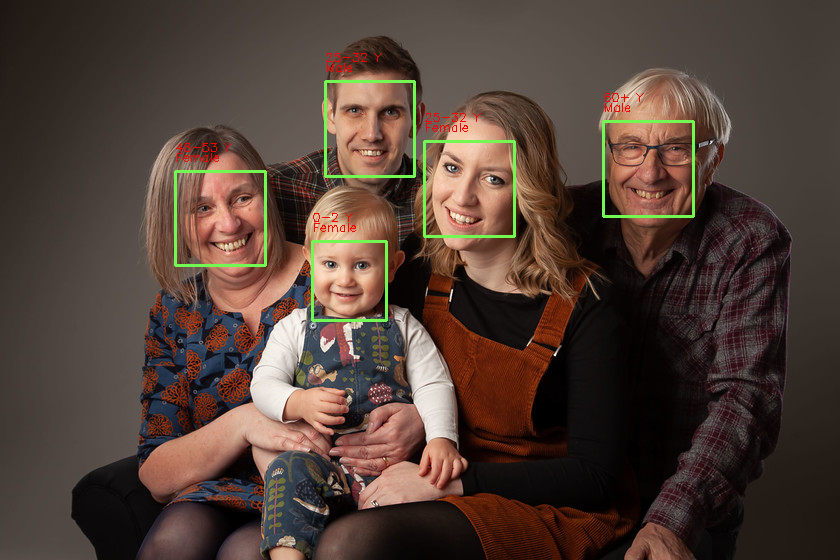

Number of faces ===> 9


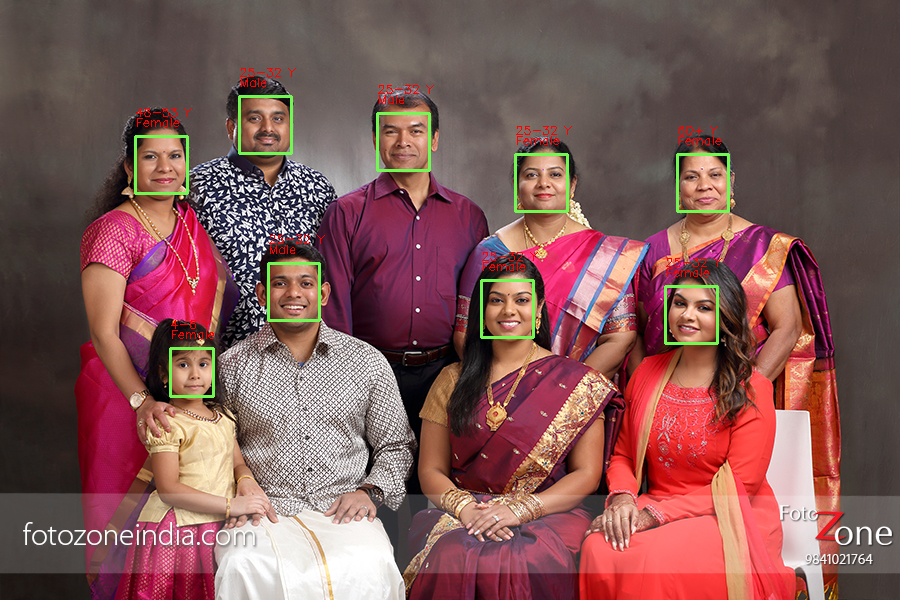

Number of faces ===> 10


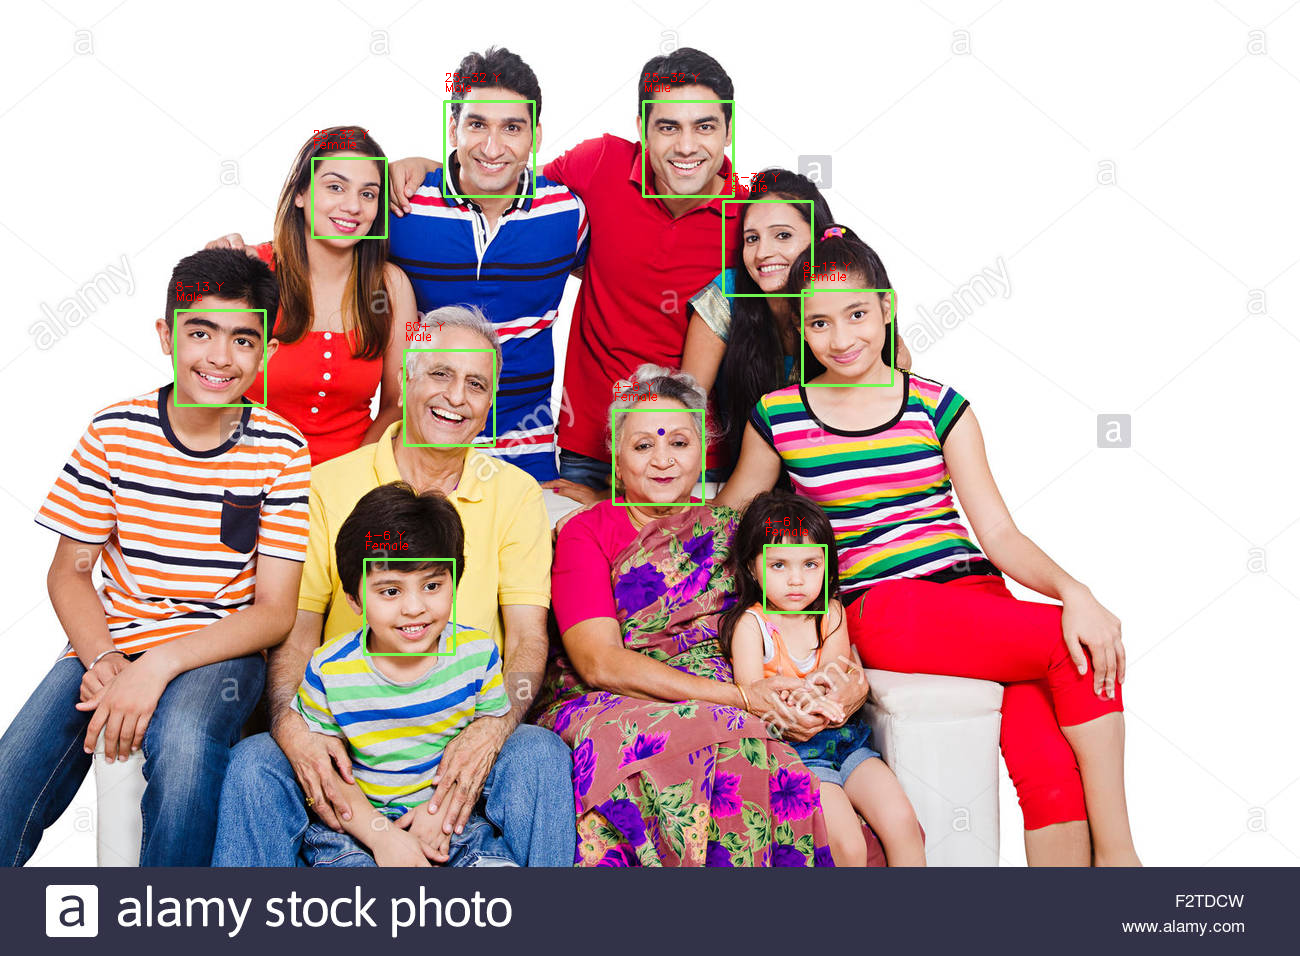

Number of faces ===> 6


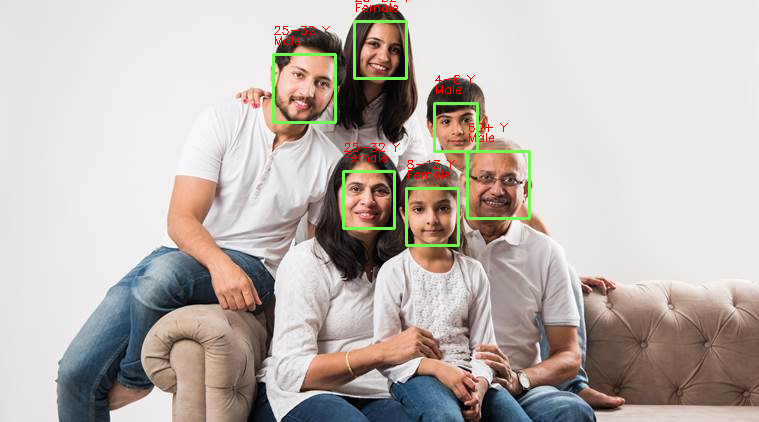

In [ ]:
play('photos/p1.jpg')
play('photos/p3.jpg')
play('photos/p6.jpg')
play('photos/p7.jpg')
play('photos/p11.jpg')
play('photos/p12.jpg')
play('photos/p14.jpg')